In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import prince
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, log_loss, roc_curve, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import seaborn as sns
from itertools import product
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from statistics import mean
import tensorflow as tf
import shap
%matplotlib inline
from xgboost import XGBClassifier

In [2]:
plt.style.use("seaborn")

## Import the data

In [3]:
IND_a= pd.read_csv("../Datasets/Kenya_2021_access.csv")
IND_u= pd.read_csv('../Datasets/Kenya_2021_usage.csv')
y= IND_a['fin34a'].copy()
w= IND_a['wgt'].copy()
IND_a= IND_a.drop(columns=['wgt','fin34a'])
IND_u= IND_u.drop(columns=['wgt','fin34a'])

In [4]:
y.value_counts()

0    746
1    254
Name: fin34a, dtype: int64

In [5]:
sup= IND_a[IND_a.columns[:4]]
sup

,female,age,educ,inc_q
0,1,1.0,1,5
1,1,3.0,1,3
2,1,1.0,1,5
3,1,3.0,2,3
4,2,1.0,3,5
...,...,...,...,...
995,2,1.0,2,2
996,2,3.0,1,3
997,2,1.0,2,3
998,2,3.0,1,5


In [6]:
contingency_table = pd.crosstab(IND_a['educ'], IND_a['inc_q'])
contingency_table

inc_q,1,2,3,4,5
educ,,,,,
1,95,70,66,47,28
2,68,91,115,169,186
3,4,3,8,9,41


In [7]:
IND_a= IND_a.drop(columns= IND_a.columns[:4])
IND_u= IND_u.drop(columns= IND_u.columns[:4])

## Implementing MCA

In [8]:
mca_a = prince.MCA(n_components=9)

# Fit the MCA model to your data
mca_a.fit(IND_a)

# Transform the data into MCA coordinates
IND_a_index = mca_a.transform(IND_a)
new_column_names_a = {i: f'aPC{i+1}' for i in IND_a_index.columns}
IND_a_index = IND_a_index.rename(columns=new_column_names_a)
IND_a_index

,aPC1,aPC2,aPC3,aPC4,aPC5,aPC6,aPC7,aPC8,aPC9
0,1.104356,0.354706,0.041393,0.795433,0.123492,0.678673,-0.271222,-0.107407,-0.087978
1,0.395629,-0.847997,0.136103,0.237434,0.043784,-0.199481,-0.074760,-0.121063,-0.078198
2,-0.325425,0.206351,0.242141,-0.197775,1.010902,-0.362587,0.710893,0.467325,-0.082685
3,-0.665059,-0.141916,-0.013900,0.165255,-0.165538,-0.102231,-0.089089,-0.583807,0.507651
4,-0.581776,0.414612,-0.386973,-0.072719,0.095173,-0.590325,0.270332,-0.322637,0.035002
...,...,...,...,...,...,...,...,...,...
995,0.395629,-0.847997,0.136103,0.237434,0.043784,-0.199481,-0.074760,-0.121063,-0.078198
996,0.711391,-0.485345,-0.127376,-0.202509,-0.098647,0.497928,0.047318,-0.090186,-0.067501
997,1.405339,0.951747,0.132470,0.362716,0.103044,-0.049659,-0.066735,-0.059209,-0.027182
998,-0.294480,0.118021,-0.159831,-0.370707,-0.050453,0.335146,-0.572701,0.303307,-0.103592


In [9]:
mca_u = prince.MCA(n_components=32)

# Fit the MCA model to your data
mca_u.fit(IND_u)

# Transform the data into MCA coordinates
IND_u_index = mca_u.transform(IND_u)
new_column_names_u = {i: f'uPC{i+1}' for i in IND_u_index.columns}
IND_u_index = IND_u_index.rename(columns=new_column_names_u)
IND_u_index

,uPC1,uPC2,uPC3,uPC4,uPC5,uPC6,uPC7,uPC8,uPC9,uPC10,...,uPC23,uPC24,uPC25,uPC26,uPC27,uPC28,uPC29,uPC30,uPC31,uPC32
0,-0.693319,-0.003874,0.077688,-0.288791,-0.047967,-0.072596,-0.044491,-0.020379,-0.024414,-0.017081,...,-0.004693,-0.027161,-0.012164,-0.004947,0.020236,0.022372,0.046344,-0.139652,-0.024168,-0.003548
1,-0.618317,-0.059197,0.104776,-0.105511,-0.090046,-0.005684,0.037789,-0.008854,-0.040494,-0.083460,...,0.015365,0.118200,-0.035104,-0.016213,0.022304,0.001769,0.042665,-0.138868,-0.029502,-0.004809
2,-0.235287,0.645295,0.006232,-0.262534,-0.018802,-0.211709,-0.037984,0.280395,0.148373,0.241824,...,0.189820,-0.013597,0.244528,0.066771,-0.027827,0.051928,-0.115657,0.042755,0.008953,-0.009132
3,0.566216,-0.197976,0.058678,-0.396870,0.010582,0.059842,-0.140863,-0.062332,0.115648,0.323166,...,0.154330,0.084163,-0.155067,0.050670,0.085197,0.040717,0.067811,0.049887,0.086020,0.259760
4,0.356469,0.296550,-0.550981,0.239763,-0.308330,0.626822,-0.087749,-0.115833,0.140326,-0.037975,...,-0.289915,0.150923,-0.334211,0.020815,0.073199,0.049722,-0.043287,0.002152,0.000835,-0.024741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.216945,-0.291106,-0.550143,0.056808,-0.092355,-0.042066,0.079261,0.131318,0.119688,-0.037524,...,-0.154256,0.018016,0.030649,-0.011629,0.177420,0.010754,0.077537,-0.059193,0.000219,-0.004325
996,-0.168877,-0.246155,-0.429260,-0.059196,0.000070,0.010825,-0.083678,0.001534,-0.063824,0.064922,...,0.386225,-0.077082,-0.055253,0.051313,-0.088821,0.094696,0.034891,0.019061,-0.002625,-0.002544
997,-0.527672,-0.063053,0.122584,-0.088127,0.119796,-0.037922,-0.243766,-0.013597,-0.272009,0.092156,...,0.105284,0.102467,-0.013442,0.020660,-0.037762,-0.050537,-0.144834,0.026949,-0.004234,0.013863
998,-0.104645,0.586486,0.008987,0.072326,0.194060,-0.014070,-0.096683,-0.099602,0.244623,-0.056402,...,0.156218,0.284684,-0.022607,-0.120891,-0.021355,-0.037443,0.065533,-0.035362,-0.014047,0.004197


In [10]:
X = pd.concat([IND_a_index, IND_u_index, sup], axis=1)
X

,aPC1,aPC2,aPC3,aPC4,aPC5,aPC6,aPC7,aPC8,aPC9,uPC1,...,uPC27,uPC28,uPC29,uPC30,uPC31,uPC32,female,age,educ,inc_q
0,1.104356,0.354706,0.041393,0.795433,0.123492,0.678673,-0.271222,-0.107407,-0.087978,-0.693319,...,0.020236,0.022372,0.046344,-0.139652,-0.024168,-0.003548,1,1.0,1,5
1,0.395629,-0.847997,0.136103,0.237434,0.043784,-0.199481,-0.074760,-0.121063,-0.078198,-0.618317,...,0.022304,0.001769,0.042665,-0.138868,-0.029502,-0.004809,1,3.0,1,3
2,-0.325425,0.206351,0.242141,-0.197775,1.010902,-0.362587,0.710893,0.467325,-0.082685,-0.235287,...,-0.027827,0.051928,-0.115657,0.042755,0.008953,-0.009132,1,1.0,1,5
3,-0.665059,-0.141916,-0.013900,0.165255,-0.165538,-0.102231,-0.089089,-0.583807,0.507651,0.566216,...,0.085197,0.040717,0.067811,0.049887,0.086020,0.259760,1,3.0,2,3
4,-0.581776,0.414612,-0.386973,-0.072719,0.095173,-0.590325,0.270332,-0.322637,0.035002,0.356469,...,0.073199,0.049722,-0.043287,0.002152,0.000835,-0.024741,2,1.0,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.395629,-0.847997,0.136103,0.237434,0.043784,-0.199481,-0.074760,-0.121063,-0.078198,-0.216945,...,0.177420,0.010754,0.077537,-0.059193,0.000219,-0.004325,2,1.0,2,2
996,0.711391,-0.485345,-0.127376,-0.202509,-0.098647,0.497928,0.047318,-0.090186,-0.067501,-0.168877,...,-0.088821,0.094696,0.034891,0.019061,-0.002625,-0.002544,2,3.0,1,3
997,1.405339,0.951747,0.132470,0.362716,0.103044,-0.049659,-0.066735,-0.059209,-0.027182,-0.527672,...,-0.037762,-0.050537,-0.144834,0.026949,-0.004234,0.013863,2,1.0,2,3
998,-0.294480,0.118021,-0.159831,-0.370707,-0.050453,0.335146,-0.572701,0.303307,-0.103592,-0.104645,...,-0.021355,-0.037443,0.065533,-0.035362,-0.014047,0.004197,2,3.0,1,5


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 64)

## Logistic regression

In [12]:
lr = LogisticRegression(solver='newton-cg', max_iter=200)

#Setting the range for class weights
weights= [.01* i for i in range(1, 101)]
weights= list(product(weights, weights))

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0: .41, 1:.75}], 
              'C': [i for i in range(1,2)]}

#Fitting grid search to the train data with 5 folds
grid_search_lr = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [13]:
print('Best parameters:', grid_search_lr.best_params_)
print('Best score:', grid_search_lr.best_score_)

Best parameters: {'C': 1, 'class_weight': {0: 0.41, 1: 0.75}}
Best score: 0.9079050641313922


In [14]:
best_lr = LogisticRegression(**grid_search_lr.best_params_)
best_lr.fit(X_train, y_train)

proba = best_lr.predict_proba(X_test)
y_= proba[:,1]

auc1 = roc_auc_score(y_test, y_, multi_class='auto')
print('AUC:', auc1)

# Calculate precision, recall, and F1-score
target_names = ["0", "1"]
treshold= 0.5
y_pred = (y_ >= treshold).astype(int)
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.986842105263158
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       152
           1       0.87      0.94      0.90        48

    accuracy                           0.95       200
   macro avg       0.92      0.95      0.93       200
weighted avg       0.95      0.95      0.95       200



In [15]:
acc= accuracy_score(y_test, y_pred)
pre= precision_score(y_test, y_pred)
rec= recall_score(y_test, y_pred)
f_1= f1_score(y_test, y_pred)
acc, rec, pre, f_1, auc1

(0.95, 0.9375, 0.8653846153846154, 0.9, 0.986842105263158)

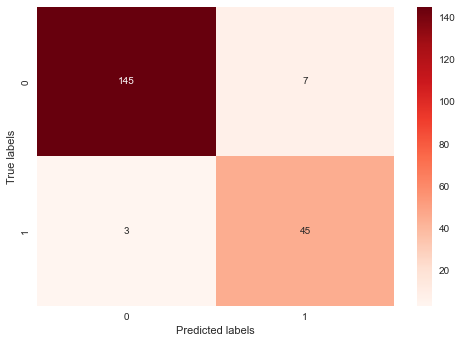

In [16]:
cm1 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm1, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [17]:
acc_1= accuracy_score(y_test, y_pred)
pre_1= precision_score(y_test, y_pred)
rec_1= recall_score(y_test, y_pred)
f_1_1= f1_score(y_test, y_pred)

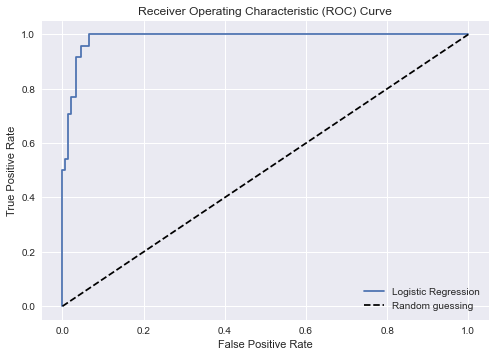

In [18]:
fpr1, tpr1, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Random Forest

In [19]:
weights= [i for i in np.linspace(0, 10,200)]
weights= list(product(weights, weights))
param_grid = {
    'n_estimators': [i for i in range(84,85)],
    'max_depth': [7],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    'max_features': ['sqrt'],
    'class_weight': [{0: 1.26, 1: 8.79}]
}
rf = RandomForestClassifier(random_state= 42)

In [20]:
grid_search_rf = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
best_rf = RandomForestClassifier(**grid_search_rf.best_params_)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
proba= best_rf.predict_proba(X_test)
y_=proba[:,1]
print(f'Best hyperparameters: {grid_search_rf.best_params_}')
print('Best score:', grid_search_rf.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters: {'class_weight': {0: 1.26, 1: 8.79}, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 84}
Best score: 0.8306107227530347


In [21]:
auc2 = roc_auc_score(y_test, proba[:,1], multi_class='auto')
print('AUC:', auc2)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9261239035087718
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       152
           1       0.67      0.77      0.72        48

    accuracy                           0.85       200
   macro avg       0.80      0.83      0.81       200
weighted avg       0.86      0.85      0.86       200



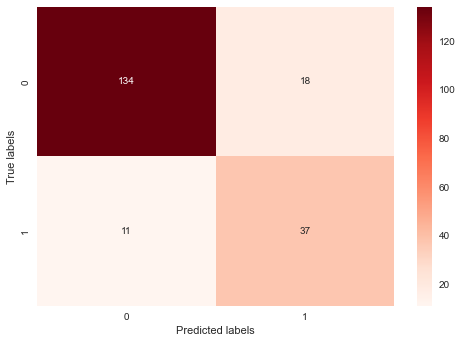

In [22]:
cm2 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm2, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [23]:
acc_2= accuracy_score(y_test, y_pred)
pre_2= precision_score(y_test, y_pred)
rec_2= recall_score(y_test, y_pred)
f_1_2= f1_score(y_test, y_pred)

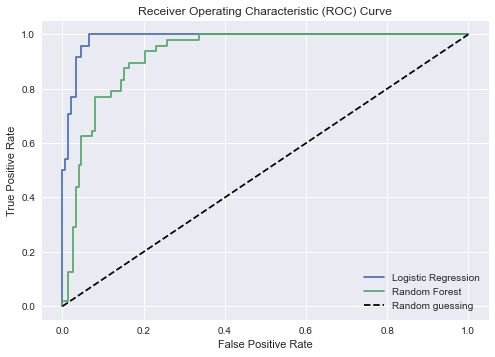

In [24]:
fpr2, tpr2, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## XG Boost

In [25]:
neg = y_train.value_counts()[0]
pos = y_train.value_counts()[1]
scale_pos_weight = neg / pos

In [26]:
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight)
param_grid = {
    'max_depth': [10],
    'learning_rate': [.1],
    'n_estimators': [376],
    'subsample': [0.5],
    'colsample_bytree': [0.5],
    'reg_alpha': [0.5],
    'reg_lambda': [0.1],
}
grid_search_xgb = GridSearchCV(estimator=xgb, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
print("Best hyperparameters: ", grid_search_xgb.best_params_)
print("Best F1 score: ", grid_search_xgb.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters:  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 376, 'reg_alpha': 0.5, 'reg_lambda': 0.1, 'subsample': 0.5}
Best F1 score:  0.8611780080043377


In [27]:
best_xgb = XGBClassifier(**grid_search_xgb.best_params_)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
proba = best_xgb.predict_proba(X_test)
y_= proba[:,1]

In [28]:
auc3 = roc_auc_score(y_test, y_, multi_class='auto')
print('AUC:', auc3)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9572368421052632
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       152
           1       0.78      0.67      0.72        48

    accuracy                           0.88       200
   macro avg       0.84      0.80      0.82       200
weighted avg       0.87      0.88      0.87       200



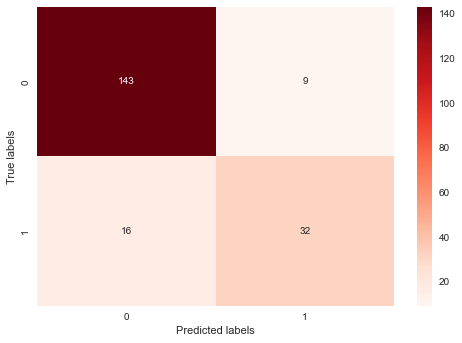

In [29]:
cm3 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm3, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [30]:
acc_3= accuracy_score(y_test, y_pred)
pre_3= precision_score(y_test, y_pred)
rec_3= recall_score(y_test, y_pred)
f_1_3= f1_score(y_test, y_pred)

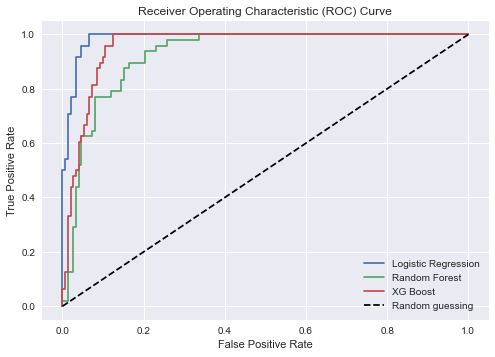

In [31]:
fpr3, tpr3, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot(fpr3, tpr3, label='XG Boost')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Artificial Neural Network

In [32]:
ann = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [33]:
ann.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [34]:
history = ann.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/50
20/20 [==============================] - 1s 16ms/step - loss: 0.6392 - precision: 0.2412 - recall: 0.2500 - val_loss: 0.5551 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 0.5412 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5088 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
20/20 [==============================] - 0s 5ms/step - loss: 0.4814 - precision: 1.0000 - recall: 0.0854 - val_loss: 0.4590 - val_precision: 0.8333 - val_recall: 0.2381
Epoch 4/50
20/20 [==============================] - 0s 5ms/step - loss: 0.4217 - precision: 1.0000 - recall: 0.1646 - val_loss: 0.4082 - val_precision: 0.8696 - val_recall: 0.4762
Epoch 5/50
20/20 [==============================] - 0s 5ms/step - loss: 0.3596 - precision: 0.9333 - recall: 0.5122 - val_loss: 0.3541 - val_precision: 0.7941 - val_recall: 0.6429
Epoch 6/50
20/20 [==============================] - 0s 6ms/step - loss: 0.3

20/20 [==============================] - 0s 5ms/step - loss: 0.0234 - precision: 0.9939 - recall: 1.0000 - val_loss: 0.2021 - val_precision: 0.8478 - val_recall: 0.9286
Epoch 47/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0253 - precision: 0.9762 - recall: 1.0000 - val_loss: 0.1955 - val_precision: 0.8605 - val_recall: 0.8810
Epoch 48/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0230 - precision: 0.9880 - recall: 1.0000 - val_loss: 0.2054 - val_precision: 0.8636 - val_recall: 0.9048
Epoch 49/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0227 - precision: 0.9820 - recall: 1.0000 - val_loss: 0.2087 - val_precision: 0.8605 - val_recall: 0.8810
Epoch 50/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0243 - precision: 0.9820 - recall: 1.0000 - val_loss: 0.2053 - val_precision: 0.8478 - val_recall: 0.9286


In [35]:
y_ = ann.predict(X_test)

7/7 [==============================] - 0s 2ms/step


In [36]:
y_= y_.reshape(y_.shape[0],)

In [37]:
y_pred= np.array([round(i) for i in y_])

In [38]:
auc4 = roc_auc_score(y_test, y_, multi_class='auto')
print('AUC:', auc4)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9835526315789475
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       152
           1       0.85      0.85      0.85        48

    accuracy                           0.93       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.93      0.93      0.93       200



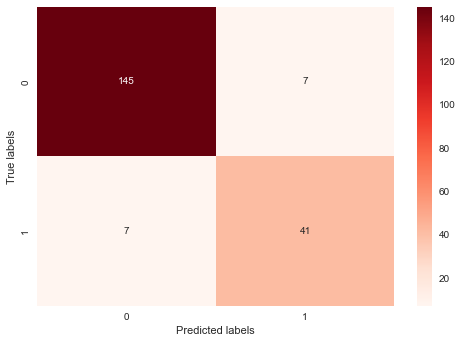

In [39]:
cm4 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm4, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [40]:
acc_4= accuracy_score(y_test, y_pred)
pre_4= precision_score(y_test, y_pred)
rec_4= recall_score(y_test, y_pred)
f_1_4= f1_score(y_test, y_pred)

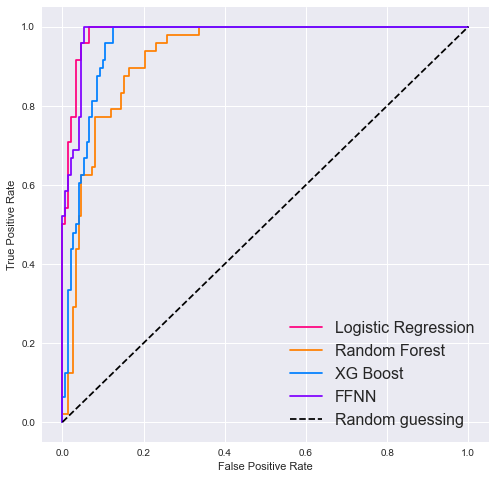

In [41]:
fpr4, tpr4, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr1, tpr1, label='Logistic Regression', color= "#ff007f")
plt.plot(fpr2, tpr2, label='Random Forest', color= "#ff7f00")
plt.plot(fpr3, tpr3, label='XG Boost', color= "#007fff")
plt.plot(fpr4, tpr4, label='FFNN', color= "#7f00ff")
plt.plot([0, 1], [0, 1], linestyle='--', color= "#000000", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(fontsize=16)
plt.savefig("../../images/roc_ken.png")
plt.show()

## Model Evaluations

In [42]:
data= {"Metrics":["Accuracy", "Recall", "Precision", "F1-Score", "AUC"],
       "LR":[round(acc_1,4), round(rec_1,4), round(pre_1,4), round(f_1_1,4), round(auc1,4)], 
       "RF":[round(acc_2,4), round(rec_2,4), round(pre_2,4), round(f_1_2,4), round(auc2,4)], 
       "XGB":[round(acc_3,4), round(rec_3,4), round(pre_3,4), round(f_1_3,4), round(auc3,4)], 
       "FFNN":[round(acc_4,4), round(rec_4,4), round(pre_4,4), round(f_1_4,4), round(auc4,4)]}
df = pd.DataFrame(data)
latex_code = df.to_latex(index=False)

# Print the LaTeX code
print(latex_code)

\begin{tabular}{lrrrr}
\toprule
  Metrics &     LR &     RF &    XGB &   FFNN \\
\midrule
 Accuracy & 0.9500 & 0.8550 & 0.8750 & 0.9300 \\
   Recall & 0.9375 & 0.7708 & 0.6667 & 0.8542 \\
Precision & 0.8654 & 0.6727 & 0.7805 & 0.8542 \\
 F1-Score & 0.9000 & 0.7184 & 0.7191 & 0.8542 \\
      AUC & 0.9868 & 0.9261 & 0.9572 & 0.9836 \\
\bottomrule
\end{tabular}



In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


## Build the index

In [43]:
eig_a= mca_a.eigenvalues_
IND_a_index["access"]= sum([IND_a_index[IND_a_index.columns[i]]*eig_a[i] for i in range(len(eig_a))])
eig_u= mca_u.eigenvalues_
IND_u_index["usage"]= sum([IND_u_index[IND_u_index.columns[i]]*eig_u[i] for i in range(len(eig_u)) ])

In [44]:
IND_fin= pd.concat([IND_a_index["access"], IND_u_index["usage"], sup, y], axis=1)

In [45]:
IND_fin["access"]= IND_fin["access"]*w
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(-1.2008180862910967, 2.548735829448405, 0.08907208474486869)

In [46]:
IND_fin["access"] -= min(IND_fin["access"])
IND_fin["access"] /= max(IND_fin["access"])

In [47]:
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(0.0, 1.0, 0.3440116344564066)

In [48]:
IND_fin["usage"]= IND_fin["usage"]*w
min(IND_fin["usage"]), max(IND_fin["usage"]), mean(IND_fin["usage"])

(-0.47573388984819764, 0.7132451929424513, -0.01498878366182279)

In [49]:
IND_fin["usage"] -= min(IND_fin["usage"])
IND_fin["usage"] /= max(IND_fin["usage"])

In [50]:
IND_fin["access"] = 1- IND_fin["access"]
#IND_fin["usage"] = 1- IND_fin["usage"]

In [51]:
IND_fin["index"]= (IND_fin['access'] + IND_fin['usage'])/2

In [52]:
fin_0= IND_fin[IND_fin["fin34a"]==0].copy()
fin_1= IND_fin[IND_fin["fin34a"]==1].copy()

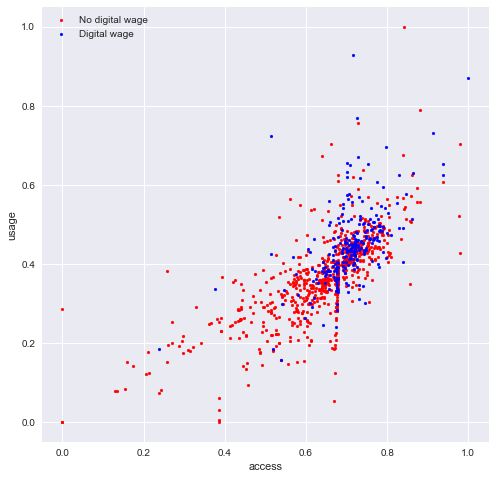

In [53]:
plt.figure(figsize=(8,8))
plt.scatter(fin_0["access"], fin_0["usage"], label= "No digital wage", s=32, color="#ff0000",
            marker='.')
plt.scatter(fin_1["access"], fin_1["usage"], label= "Digital wage", s=32, color="#0000ff",
            marker='.')
plt.xlabel("access")
plt.ylabel("usage")
plt.legend()
#plt.xlim([0.25,1.05])
#plt.ylim([-0.05,.75])
plt.savefig('../../images/find_ken')
plt.show()

In [54]:
IND_fin['access'].describe()

count    1000.000000
mean        0.655988
std         0.119631
min         0.000000
25%         0.614358
50%         0.677271
75%         0.720384
max         1.000000
Name: access, dtype: float64

In [55]:
IND_fin['usage'].describe()

count    1000.000000
mean        0.387513
std         0.109937
min         0.000000
25%         0.333755
50%         0.391124
75%         0.443947
max         1.000000
Name: usage, dtype: float64

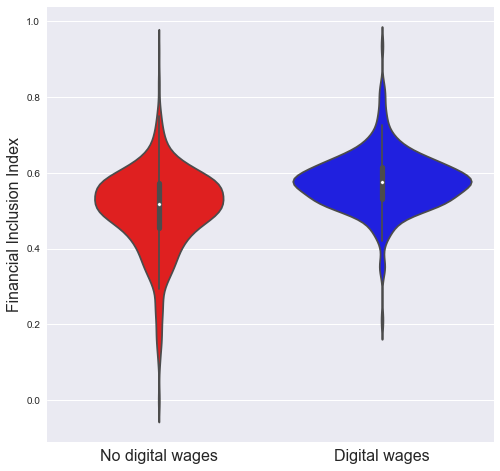

In [56]:
colors = ["#ff0000", "#0000ff"]
plt.figure(figsize=(8, 8))
sns.violinplot(x='fin34a', y='index', data=IND_fin, palette= colors)
custom_category_names = ['No digital wages', 'Digital wages']
plt.xticks(range(len(custom_category_names)), custom_category_names, fontsize=16)
plt.xlabel('')
plt.ylabel('Financial Inclusion Index', fontsize=16)

plt.savefig('../../images/ind_ken')

# Show the plot
plt.show()

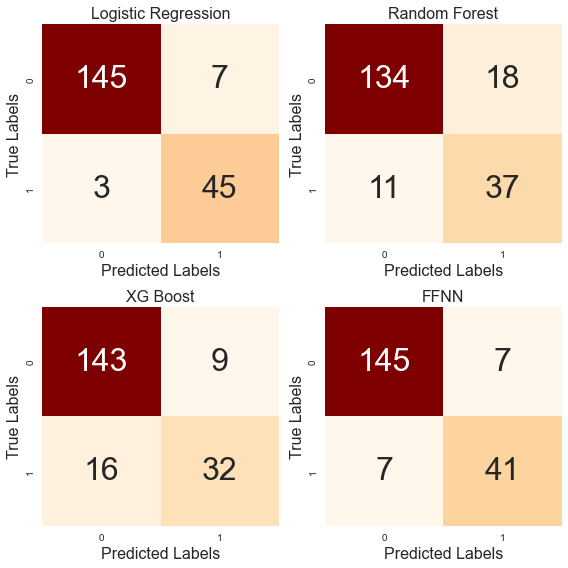

In [57]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
cm= [cm1, cm2, cm3, cm4]
mods= ["Logistic Regression", "Random Forest", "XG Boost", "FFNN"]
# Compute and plot confusion matrices
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(cm[i], annot=True, cmap="OrRd", fmt='d', ax=ax, cbar=False, 
                annot_kws={"fontsize": 32})
    ax.set_title(f"{mods[i]}", fontsize=16)
    ax.set_xlabel("Predicted Labels", fontsize=16)
    ax.set_ylabel("True Labels", fontsize=16)

# Adjust subplot spacing
plt.tight_layout()
plt.savefig('../../images/comat_ken.png')
# Display the plot
plt.show()

## Feature Importance

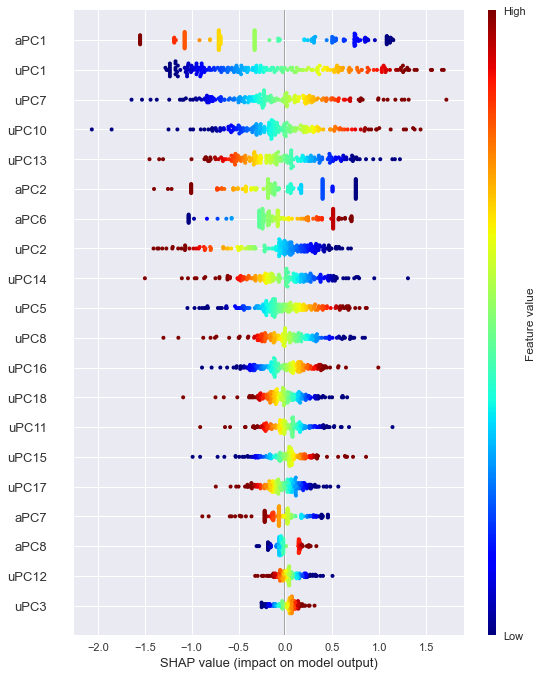

In [66]:
explainer = shap.Explainer(best_lr, X_train)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, X_test, cmap= "jet")

In [59]:
u= mca_u.column_contributions_
u= u.rename(columns=new_column_names_u)
a= mca_a.column_contributions_
a= a.rename(columns=new_column_names_a)

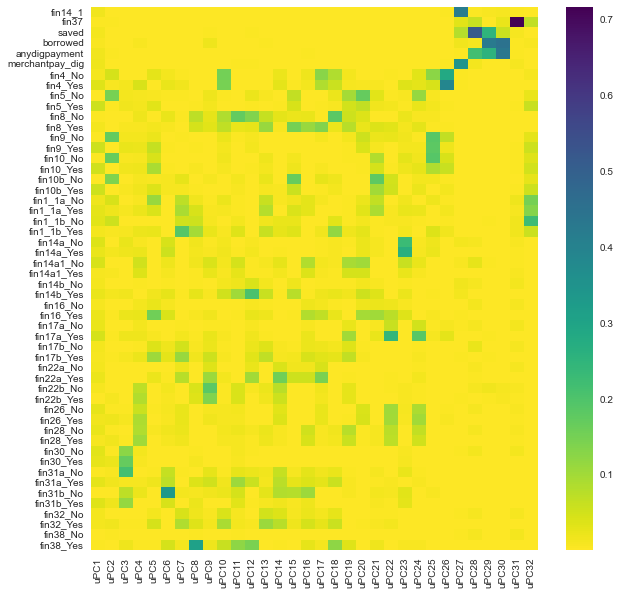

In [60]:
plt.figure(figsize=(10,10))
sns.heatmap(u, annot=False, cmap="viridis_r", cbar=True)#, annot_kws={"fontsize": 32})
plt.savefig('../../images/us_ken.png')
plt.show()

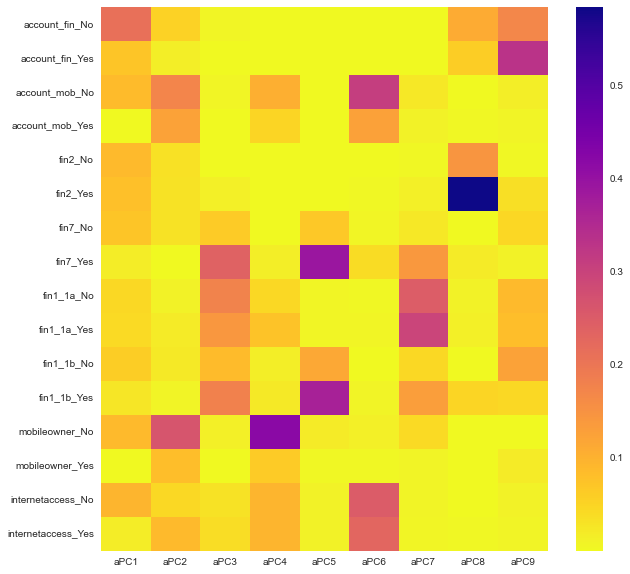

In [61]:
plt.figure(figsize=(10,10))
sns.heatmap(a, annot=False, cmap="plasma_r", cbar=True)#, annot_kws={"fontsize": 32})
plt.savefig('../../images/acc_ken.png')
plt.show()

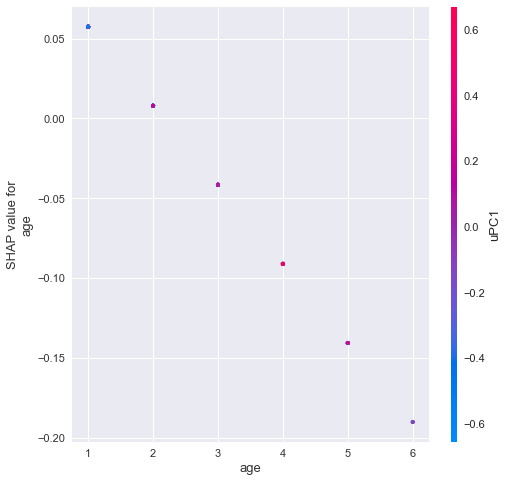

In [62]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('age', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

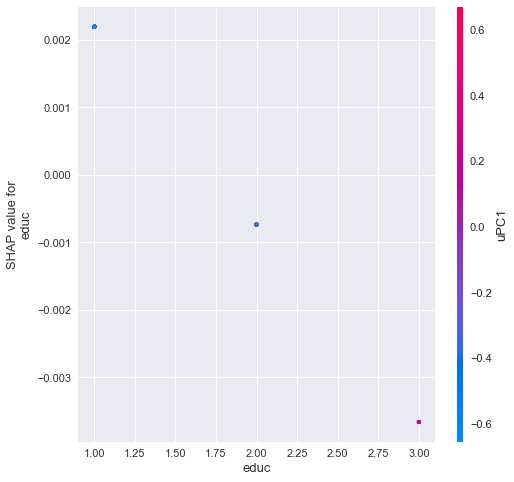

In [63]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('educ', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

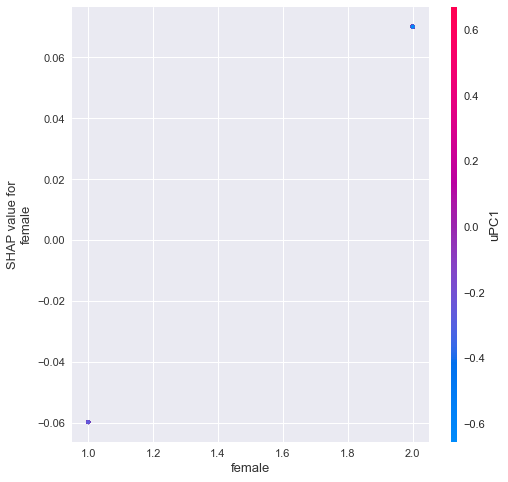

In [64]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('female', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

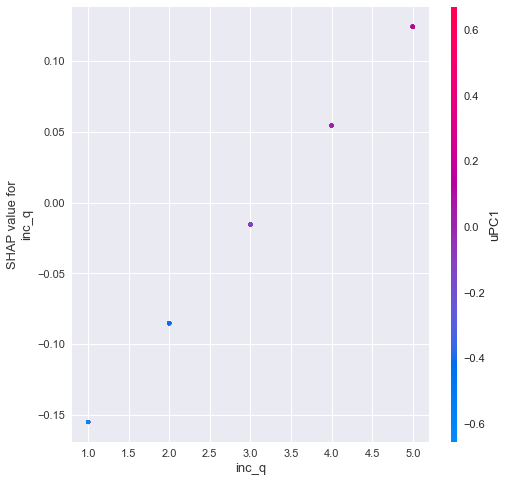

In [65]:
ig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('inc_q', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()